In [1]:
import os
import ssl
import time
import numpy
import random
import pandas

In [2]:
import torch
from Model import CNN
from torch import nn, optim
from Plot import plot_metrics
from Dataset import ImageDataset
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

In [3]:
def worker_init_fn(worker_id):
    torch.manual_seed(worker_id)
    torch.cuda.manual_seed(worker_id)
    torch.cuda.manual_seed_all(worker_id)

In [4]:
def set_seed(seed):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    numpy.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [5]:
def load_data(path):
    """Loads the data from the given path."""
    folders = [name for name in os.listdir(path) if not name.startswith('.')]
    
    numbers = 0
    for n in range(len(folders)):
        patient_id = folders[n]
        for c in [0, 1]:
            patient_path = path + patient_id 
            class_path = patient_path + "/" + str(c) + "/"
            files = os.listdir(class_path)
            numbers += len(files)
            
    data = pandas.DataFrame(index=numpy.arange(0, numbers), columns=['patient_id', 'path', 'target'])
    
    index = 0
    for n in range(len(folders)):
        patient_id = folders[n]
        patient_path = path + patient_id 
        for c in [0, 1]:
            class_path = patient_path + '/' + str(c) + '/'
            files = os.listdir(class_path)
            for m in range(len(files)):
                image_path = files[m]
                data.loc[index, 'target'] = int(c)
                data.loc[index, 'patient_id'] = patient_id
                data.loc[index, 'path'] = class_path + image_path
                index += 1
    return data

In [6]:
def value(loader, device):
    mean = 0.0
    variance = 0.0
    number_ones = 0
    number_zeros = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        images = images.view(images.size(0), images.size(1), -1)
        variance += images.var(2).sum(0)
        mean += images.mean(2).sum(0) 

        number_ones += torch.sum(labels == 1).item()
        number_zeros += torch.sum(labels == 0).item()

    number = number_ones + number_zeros
    weight_ones = 1 / number_ones * number / 2.0
    weight_zeros = 1 / number_zeros * number / 2.0
    weight = torch.tensor([weight_zeros, weight_ones], dtype=torch.float32).to(device)
    
    mean /= number
    variance /= number
    return weight, mean, variance

In [7]:
def dataset(data, device, batch_size, worker_size):
    """Returns the training and testing datasets."""
    train_data, evaluation_data = train_test_split(data, test_size=0.2, random_state=0)
    validation_data, test_data = train_test_split(evaluation_data, test_size=0.5, random_state=0)
    
    initial_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((50, 50), antialias=True)])
    
    initial_dataset = ImageDataset(dataframe=train_data, transform=initial_transform)
    initial_loader = DataLoader(dataset=initial_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=worker_size, worker_init_fn=worker_init_fn)

    weight, mean, variance = value(initial_loader, device)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((50, 50), antialias=True), transforms.Normalize(mean, variance.sqrt())])
    
    test_dataset = ImageDataset(dataframe=test_data, transform=transform)
    train_dataset = ImageDataset(dataframe=train_data, transform=transform)
    validation_dataset = ImageDataset(dataframe=validation_data, transform=transform)

    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=worker_size, worker_init_fn=worker_init_fn)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=worker_size, worker_init_fn=worker_init_fn)
    validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=worker_size, worker_init_fn=worker_init_fn)
    
    return weight, train_loader, validation_loader, test_loader

In [8]:
def train_and_validate(model, train_loader, validation_loader, loss_function, optimizer, epochs, device):
    """train and validate"""
    
    train_losses = []
    train_scores = []
    train_recalls = []
    train_precisions = []
    train_accuracies = []
    
    validation_losses = []
    validation_scores = []
    validation_recalls = []
    validation_precisions = []
    validation_accuracies = []

    for epoch in range(epochs):
        start_time = time.time()
        
        # Training Phase
        model.train()
        all_train_labels = []
        all_train_predictions = []
        train_loss, correct_train, total_train = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            optimizer.zero_grad(set_to_none=True)
            loss = loss_function(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            predictions = torch.max(outputs, 1)[1]
            total_train += labels.size(0)
            correct_train += (predictions == labels).sum().item()

            all_train_labels.extend(labels.cpu().numpy())
            all_train_predictions.extend(predictions.cpu().numpy())
        
        train_loss /= len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        train_precision, train_recall, train_score, train_support = precision_recall_fscore_support(all_train_labels, all_train_predictions, average='macro')
        
        train_losses.append(train_loss)
        train_scores.append(train_score)
        train_recalls.append(train_recall)
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)

        # Validation Phase
        model.eval()
        all_validation_labels = []
        all_validation_predictions = []
        validation_loss, correct_validation, total_validation = 0, 0, 0

        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = loss_function(outputs, labels)
                validation_loss += loss.item() * images.size(0)
                
                predictions = torch.max(outputs, 1)[1]
                total_validation += labels.size(0)
                correct_validation += (predictions == labels).sum().item()

                all_validation_labels.extend(labels.cpu().numpy())
                all_validation_predictions.extend(predictions.cpu().numpy())
        
        validation_loss /= len(validation_loader.dataset)
        validation_accuracy = correct_validation / total_validation
        validation_precision, validation_recall, validation_score, validation_support = precision_recall_fscore_support(all_validation_labels, all_validation_predictions, average='macro')

        validation_losses.append(validation_loss)
        validation_scores.append(validation_score)
        validation_recalls.append(validation_recall)
        validation_accuracies.append(validation_accuracy)
        validation_precisions.append(validation_precision)
        
        end_time = time.time()
        print(f'Epoch [{epoch + 1} / {epochs}], time: {(end_time - start_time) / 60:.2f} minutes')
        print(f'Train metrics - losses: {train_loss:.4f}, scores: {train_score:.4f}, recalls: {train_recall:.4f}, precisions: {train_precision:.4f}, accuracies: {train_accuracy:.4f}')
        print(f'Validation metrics - losses: {validation_loss:.4f}, scores: {validation_score:.4f}, recalls: {validation_recall:.4f}, precisions: {validation_precision:.4f}, accuracies: {validation_accuracy:.4f}')
    
    # Store metrics
    train_metrics = {
        'losses': train_losses,
        'scores': train_scores, 
        'recalls': train_recalls,
        'precisions': train_precisions,
        'accuracies': train_accuracies,
    }

    validation_metrics = {
        'losses': validation_losses,
        'scores': validation_scores, 
        'recalls': validation_recalls,
        'precisions': validation_precisions,
        'accuracies': validation_accuracies,
    }
    
    return train_metrics, validation_metrics

In [ ]:
def predict(model, loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss += loss_function(outputs, labels).item() * images.size(0)
            
            total += labels.size(0)
            predictions = torch.max(outputs, 1)[1]
            correct += (predictions == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    loss /= len(validation_loader.dataset)
    accuracy = correct_validation / total_validation
    precision, recall, score, support = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
    
    metrics = {
        'loss': loss,
        'score': score, 
        'recall': recall,
        'accuracy': accuracy,
        'precision': precision,
    }
    return metrics

In [9]:
set_seed(0)
%matplotlib inline
ssl_create_default_https_context = ssl._create_unverified_context

In [10]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cpu


In [11]:
PATH = os.getcwd()
DATA_PATH = os.path.join(PATH, 'DATA/')
PLOT_PATH = os.path.join(PATH, 'PLOT/')
DATA = load_data(DATA_PATH)

In [12]:
WORKER_SIZE = 4
EPOCH_SIZE = 30
BATCH_SIZE = 1024
WEIGHT_DECAY = 0.0001
LEARNING_RATE = 0.0005

In [13]:
WEIGHT, TRAIN_LOADER, VALIDATION_LOADER, TEST_LOADER = dataset(DATA, DEVICE, BATCH_SIZE, WORKER_SIZE)
print(f"Train size: {len(TRAIN_LOADER.dataset)}, Validation size: {len(VALIDATION_LOADER.dataset)}, Test size: {len(TEST_LOADER.dataset)}")

Train size: 222019, Validation size: 27752, Test size: 27753


In [14]:
LOSS_FUNCTION = nn.CrossEntropyLoss(weight=WEIGHT)
MODEL = CNN().to(DEVICE)
print(MODEL)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): Dropout(p=0.25, inplace=False)
  )
  (fc_layer): Sequential(
    (0): Linear

In [15]:
OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
TRAIN_METRICS, VALIDATION_METRICS = train_and_validate(MODEL, TRAIN_LOADER, VALIDATION_LOADER, LOSS_FUNCTION, OPTIMIZER, EPOCH_SIZE, DEVICE)

Epoch [1 / 30], time: 9.42 minutes
Train metrics - losses: 0.4316, scores: 0.7693, recalls: 0.8124, precisions: 0.7611, accuracies: 0.7900
Validation metrics - losses: 0.3708, scores: 0.8050, recalls: 0.8418, precisions: 0.7929, accuracies: 0.8246
Epoch [2 / 30], time: 9.38 minutes
Train metrics - losses: 0.3767, scores: 0.8097, recalls: 0.8419, precisions: 0.7963, accuracies: 0.8319
Validation metrics - losses: 0.3587, scores: 0.8200, recalls: 0.8512, precisions: 0.8065, accuracies: 0.8403
Epoch [3 / 30], time: 9.29 minutes
Train metrics - losses: 0.3632, scores: 0.8203, recalls: 0.8491, precisions: 0.8065, accuracies: 0.8427
Validation metrics - losses: 0.3399, scores: 0.8378, recalls: 0.8568, precisions: 0.8257, accuracies: 0.8603
Epoch [4 / 30], time: 9.32 minutes
Train metrics - losses: 0.3552, scores: 0.8238, recalls: 0.8522, precisions: 0.8097, accuracies: 0.8459
Validation metrics - losses: 0.3424, scores: 0.8289, recalls: 0.8579, precisions: 0.8150, accuracies: 0.8491
Epoch [5

In [16]:
%env PATH=/global/homes/y/yhzhang/opt/texlive/bin/x86_64-linux:$PATH
pyplot.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
pyplot.rcParams['pgf.texsystem'] = 'pdflatex'
pyplot.rcParams['text.usetex'] = True
pyplot.rcParams['font.size'] = 20

env: PATH=/global/homes/y/yhzhang/opt/texlive/bin/x86_64-linux:/pscratch/sd/y/yhzhang/MLConda


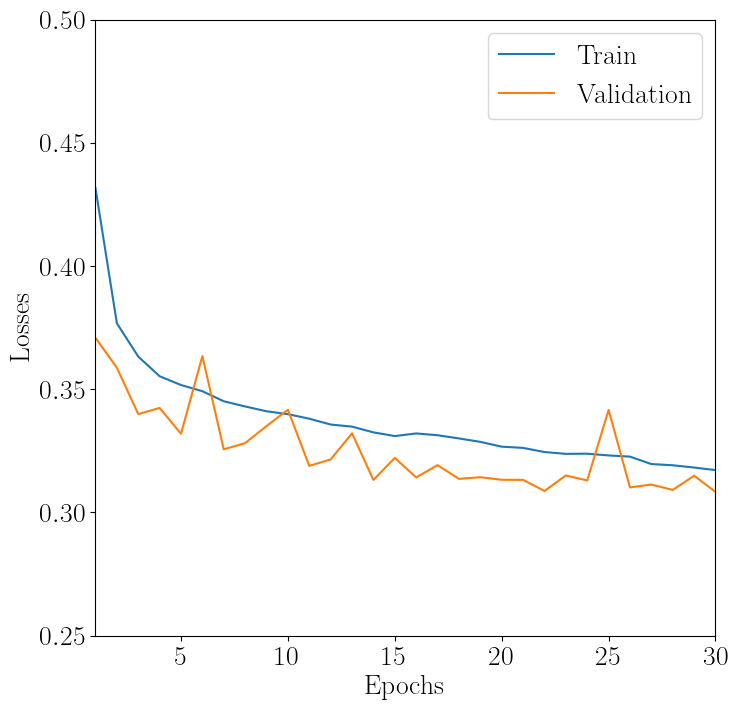

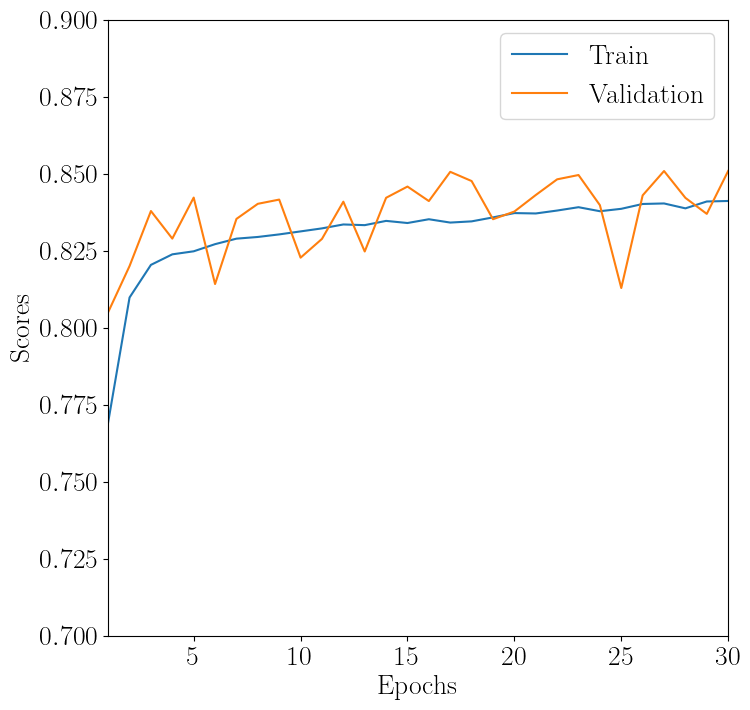

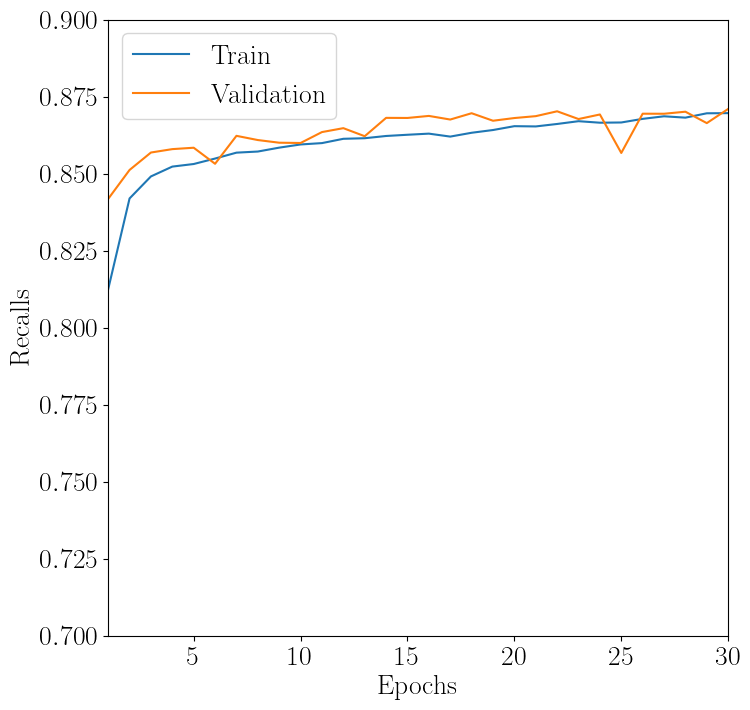

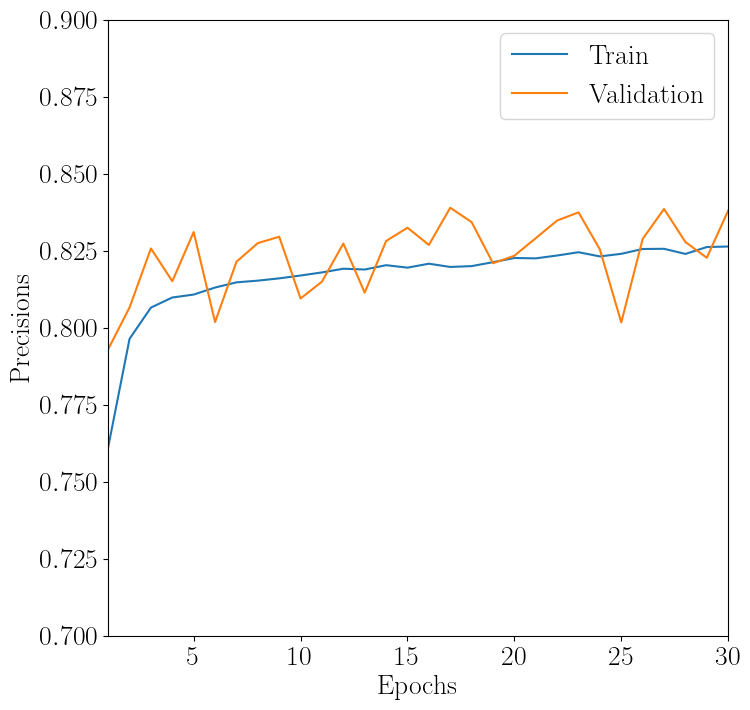

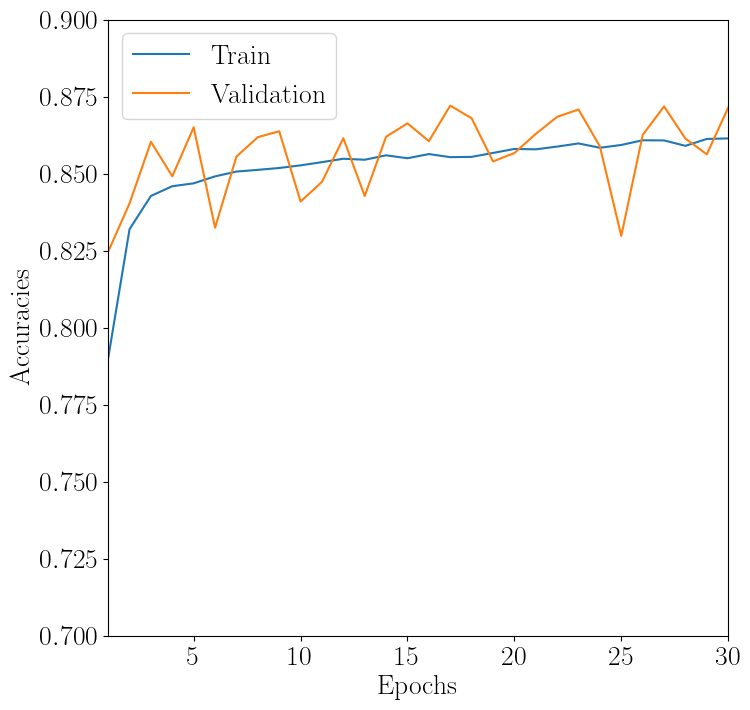

In [29]:
plot_metrics(PLOT_PATH, EPOCH_SIZE, TRAIN_METRICS, VALIDATION_METRICS)

In [ ]:
torch.save(MODEL, os.path.join(PATH, 'MODEL.pth'))

In [ ]:
TEST_METRICS = predict(MODEL, LOADER, DEVICE)
print(TEST_METRICS)